# Exploring TRIM dataset

Here, I'm removing bromodomains with fewer than 50 entries after removing salts and checking for duplicates between the manually curated data and ChEMBL
* After that, also make a separate sheet with badly behaved compounds (with morgan fps) removed

In [1]:
import sys
import os
from itertools import combinations
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# RDKit imports 
from rdkit import Chem
from rdkit import DataStructs
from rdkit.DataManip.Metric import GetTanimotoSimMat, GetTanimotoDistMat
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors, rdMolDescriptors
from rdkit.Chem import PandasTools

# logging
import logging
logging.basicConfig(format='%(message)s')
log = logging.getLogger()
log.setLevel(logging.INFO)

sns.set_style('ticks')
plt.style.use('../../2021.08_plotstyle.mplstyle')
sns.set_palette('colorblind')

# Load data

Try-except block since it was being weird, but moving data to a new csv fixed it

In [3]:
file = '2023.06.13_brd_ligands_init.csv'

try:
    data = pd.read_csv(file, index_col=0)
    print('ran try block')
except UnicodeDecodeError:
   data = pd.read_csv(file, index_col=0, encoding='ISO-8859-1')
   print('ran except block')

data.shape

ran try block


(11219, 10)

## Make Canonical SMILES column

Add this to the dataframe first, then check for duplicates 
* Using Canon_SMILES + Protein to check for duplicates
* I did try substructure matching, but it got upset by the chiral molecules, so sticking to Canon_SMILES seems safer

In [4]:
canon_smiles = [Chem.CanonSmiles(s, useChiral=1) for s in data["SMILES"]]

data["Canon_SMILES"] = canon_smiles
data["Canon_SMILES"].value_counts()

[15:17:47] WARNING: not removing hydrogen atom without neighbors
[15:17:48] WARNING: not removing hydrogen atom without neighbors


Cc1cc2c(cc1N1C(=O)c3cccc4c(CCCO)ccc(c34)C1=O)n(C)c(=O)n2C                   41
Cc1cc2c(-c3ccco3)cnc(N[C@@H]3CCN(C)C[C@H]3C(=O)NC3CCCCC3)c2[nH]c1=O         34
Cc1ccc2ncccc2c1-c1cc(-c2c(C)noc2C)cc2nc(C3CC3)[nH]c12                       34
CNC(=O)c1cc(C(=O)N[C@H]2[C@@H]3COC[C@@H]32)cc2c1O[C@H](CF)[C@H]2c1ccccc1    34
CNC(=O)c1cc(C(=O)NC2CC2)cn(Cc2ccccc2)c1=O                                   34
                                                                            ..
CCn1c2c(c(=O)[nH]c1=O)C(c1ccc(C(F)(F)F)cc1)C1=C(COC1=O)N2                    1
Cc1c(-c2nc3cnc(N4CCN(C)CC4)cc3n2Cc2ccccc2)cn(C)c(=O)c1C                      1
CCN1C(=O)c2cccc3c(S(=O)(=O)NC4CCOCC4)ccc1c23                                 1
Cc1noc(C)c1-c1cc(O)cc(CN2CCN(C)CC2)c1                                        1
CCN(CC)CC1CN(Cc2ccc3c(c2)n(C)c(=O)n3C)CCO1                                   1
Name: Canon_SMILES, Length: 5562, dtype: int64

Check for duplicated Canon_SMILES-protein combinations, looks like there are duplicates here!

It looks like one of the manually curated datasets has now been added to chembl, so I want to remove it

In [5]:
data.duplicated(subset=["Protein", "Canon_SMILES"]).value_counts()

False    11183
True        36
dtype: int64

In [7]:
# show ALL duplicated values, can see that one paper was added into chembl!

data[data.duplicated(subset=["Protein", "Canon_SMILES"], keep=False)].sort_values(by=["Protein", "Canon_SMILES"])

,SMILES,Source,Source description,Protein,Assay,Type,Unit,Value,pK_pIC50,Class,Canon_SMILES
CDX-code,,,,,,,,,,,
CHEMBL5196972,COc1ccc(C2CC2)cc1S(=O)(=O)Nc1ccc2c(c1)CCN2C(C)=O,CHEMBL5154837,ChEMBL-33,BRPF1B,Inhibition of BRPF1 (unknown origin) measured ...,IC50,nM,1160.0,5.935542,1,COc1ccc(C2CC2)cc1S(=O)(=O)Nc1ccc2c(c1)CCN2C(C)=O
20l,COC1=CC=C(C2CC2)C=C1S(=O)(=O)NC1=C/C=C2C(=C/1)...,10.1016/j.ejmech.2022.114311,"Hand curated, Literature",BRPF1B,AlphaScreen,IC50,nM,1160.0,5.935542,1,COc1ccc(C2CC2)cc1S(=O)(=O)Nc1ccc2c(c1)CCN2C(C)=O
CHEMBL5192612,CC(=O)N1CCc2cc(S(=O)(=O)Nc3cc(-c4ccco4)c(F)cc3...,CHEMBL5154837,ChEMBL-33,TRIM24,Inhibition of TRIM24 (unknown origin) measured...,IC50,nM,32980.0,4.481749,0,CC(=O)N1CCc2cc(S(=O)(=O)Nc3cc(-c4ccco4)c(F)cc3...
19p,CC(=O)N1CCC2=CC(S(=O)(=O)NC3=C(F)C=C(F)C(C4=CC...,10.1016/j.ejmech.2022.114311,"Hand curated, Literature",TRIM24,AlphaScreen,IC50,nM,32980.0,4.481749,0,CC(=O)N1CCc2cc(S(=O)(=O)Nc3cc(-c4ccco4)c(F)cc3...
CHEMBL5184073,CC(=O)N1CCc2cc(S(=O)(=O)Nc3cc(-c4ccco4)ccc3C)c...,CHEMBL5154837,ChEMBL-33,TRIM24,Inhibition of TRIM24 (unknown origin) measured...,IC50,nM,18510.0,4.732594,0,CC(=O)N1CCc2cc(S(=O)(=O)Nc3cc(-c4ccco4)ccc3C)c...
...,...,...,...,...,...,...,...,...,...,...,...
20c,COC1=CC=C(S(=O)(=O)NC2=CC=C3C(=C2)CCN3C(C)=O)C=C1,10.1016/j.ejmech.2022.114311,"Hand curated, Literature",TRIM24,AlphaScreen,IC50,nM,17370.0,4.760200,0,COc1ccc(S(=O)(=O)Nc2ccc3c(c2)CCN3C(C)=O)cc1
CHEMBL1457272,COc1cccc(NS(=O)(=O)c2ccc3c(c2)CCN3C(C)=O)c1,CHEMBL5154837,ChEMBL-33,TRIM24,Inhibition of TRIM24 (unknown origin) measured...,IC50,nM,38370.0,4.416008,0,COc1cccc(NS(=O)(=O)c2ccc3c(c2)CCN3C(C)=O)c1
5b,COC1=CC=CC(NS(=O)(=O)C2=CC3=C(C=C2)N(C(C)=O)CC...,10.1016/j.ejmech.2022.114311,"Hand curated, Literature",TRIM24,AlphaScreen,IC50,nM,38370.0,4.416008,0,COc1cccc(NS(=O)(=O)c2ccc3c(c2)CCN3C(C)=O)c1


In [8]:
# remove duplicated values, keeping the chembl entry

data = data.drop_duplicates(subset=["Protein", "Canon_SMILES"], keep="first")

In [9]:
data.shape

(11183, 11)

In [10]:
data.columns

Index(['SMILES', 'Source', 'Source description', 'Protein', 'Assay', 'Type',
       'Unit', 'Value', 'pK_pIC50', 'Class', 'Canon_SMILES'],
      dtype='object')

# Sort data

I want the data sorted in a particular order 
* First, convert Type to uppercase, otherwise the sorting is a problem (case sensitive sort)
* Then sort by Protein, then assay (so that Kd and IC50 data comes before Tm), then class (so that actives come before inactives)

In [11]:
data["Type"] = data["Type"].str.upper()

In [12]:
data.sort_values(by=["Protein","Class","Type"], ascending=[True,False,False])

,SMILES,Source,Source description,Protein,Assay,Type,Unit,Value,pK_pIC50,Class,Canon_SMILES
CDX-code,,,,,,,,,,,
CHEMBL3780128,CCN1C(=O)c2cccc3c(NS(=O)(=O)c4ccc(F)cc4)ccc1c23,CHEMBL3779865,ChEMBL-33,ASH1L,Binding affinity to human His6-tagged ASH1L (E...,DELTA TM,degrees C,3.100,NaN,1,CCN1C(=O)c2cccc3c(NS(=O)(=O)c4ccc(F)cc4)ccc1c23
CHEMBL3780059,CCN1C(=O)c2cccc3c(NS(=O)(=O)c4ccc(F)cc4F)ccc1c23,CHEMBL3779865,ChEMBL-33,ASH1L,Binding affinity to human His6-tagged ASH1L (E...,DELTA TM,degrees C,2.900,NaN,1,CCN1C(=O)c2cccc3c(NS(=O)(=O)c4ccc(F)cc4F)ccc1c23
CHEMBL3780398,CCN1C(=O)c2cccc3c(S(=O)(=O)Nc4ccc(F)cc4)ccc1c23,CHEMBL3779865,ChEMBL-33,ASH1L,Binding affinity to human His6-tagged ASH1L (E...,DELTA TM,degrees C,2.000,NaN,1,CCN1C(=O)c2cccc3c(S(=O)(=O)Nc4ccc(F)cc4)ccc1c23
CHEMBL4086276,Cc1cc2c(cc1N1C(=O)c3cccc4c(CCCO)ccc(c34)C1=O)n...,CHEMBL4049437,ChEMBL-33,ASH1L,Inhibition of ASH1L (unknown origin) assessed ...,DELTATM,K,1.500,NaN,0,Cc1cc2c(cc1N1C(=O)c3cccc4c(CCCO)ccc(c34)C1=O)n...
CHEMBL3769507,CCn1cc(-c2cccc(C(F)(F)F)c2)c2sc(C(=N)NC3CCS(=O...,CHEMBL4649992,ChEMBL-33,ASH1L,Thermal Shift Assay. Domain start/stop: E2433-...,DELTA TM,C,1.170,NaN,0,CCn1cc(-c2cccc(C(F)(F)F)c2)c2sc(C(=N)NC3CCS(=O...
...,...,...,...,...,...,...,...,...,...,...,...
CHEMBL2177300,CC(=O)N1c2ccc(-c3ccc(C(=O)O)cc3)cc2[C@H](Nc2cc...,10.1021/jm5010539,"Hand curated, Literature",WDR9-2,Bromoscan,KD,nM,19950.000,4.700057,0,CC(=O)N1c2ccc(-c3ccc(C(=O)O)cc3)cc2[C@H](Nc2cc...
CHEMBL3786012,Cc1[nH]c(-c2cc(S(C)(=O)=O)ccc2Oc2ccc(F)cc2F)c2...,CHEMBL4038268,ChEMBL-33,WDR9-2,Inhibition of human WDR9 bromodomain 2 (A1310 ...,IC50,nM,10001.000,4.999957,0,Cc1[nH]c(-c2cc(S(C)(=O)=O)ccc2Oc2ccc(F)cc2F)c2...
CHEMBL4088466,Cn1cc(-c2cc(S(C)(=O)=O)ccc2Oc2ccc(F)cc2F)c2cc[...,CHEMBL4038268,ChEMBL-33,WDR9-2,Inhibition of human WDR9 bromodomain 2 (A1310 ...,IC50,nM,10001.000,4.999957,0,Cn1cc(-c2cc(S(C)(=O)=O)ccc2Oc2ccc(F)cc2F)c2cc[...


## Do some data preparation and checks

Learnt this from https://github.com/vfscalfani/CSN_tutorial, where they checked for disconnected SMILES and for molecules with more than one fragment
* Check for disconnected SMILES via string matching 
* Then double check with RdKit, to make sure that all molecules have only one fragment

Looks like there are some molecules with disconnected SMILES/more than one fragment (i.e. salts)

In [13]:
# Check for presence of disconnected SMILES via string matching

data_2 = data[~data["Canon_SMILES"].str.contains("\.")].copy()
len(data_2)

10831

In [14]:
# Double check for disconnected fragments (in case the dot disconnect bond is used with ring closures

num_frags = []
for smi in data_2["Canon_SMILES"]:
    mol = Chem.MolFromSmiles(smi, sanitize=True)
    num_frags.append(len(Chem.GetMolFrags(mol)))

all(frag == 1 for frag in num_frags)

True

# Drop bromodomains with fewer than 50 entries 

See how many survive
* Do this prior to removing enantiomers

In [15]:
few_points = (data_2["Protein"].value_counts() < 50) # boolean
few_points_idx = few_points[few_points].index

Remove proteins with <50 data points

In ChEMBL-33:
* 10455 data points remaining, 5376 unique ligands
* 33 unique bromodomains, top is still BRD4-1

Compare with ChEMBL-32
* 9634 data points remaining 
* 31 unique bromodomains (due to BRPF1A now being included), 5006 unique ligands

In [16]:
data_2 = data_2.loc[~data_2["Protein"].isin(few_points_idx)]

In [17]:
print(data_2.shape)
print(data_2["Canon_SMILES"].describe())
print(data_2["Protein"].describe())

(10455, 11)
count                                                 10455
unique                                                 5376
top       Cc1cc2c(-c3ccco3)cnc(N[C@@H]3CCN(C)C[C@H]3C(=O...
freq                                                     28
Name: Canon_SMILES, dtype: object
count      10455
unique        33
top       BRD4-1
freq        3143
Name: Protein, dtype: object


Save data_2 (with enantiomers) as a cleaned copy of the data

In [18]:
data_2.to_csv("2023.06.13_brd_ligands_cleaned.csv")

# Check for ligands that can't be distinguished w/ Morgan FPs

Since I'm training with Morgan fingerprints, it's good to check for duplicate pairs here
* Can save a csv file with problematic duplicates removed!

Keep unique ligands, can also use this for Murcko scaffolds and Tanimoto similarity

Interestingly, after converting to Canon_SMILES, one of the SMILES becomes the same...

In [19]:
assert(len(data_2["Canon_SMILES"].unique()) == len(data_2["SMILES"].unique()))

AssertionError: 

In [22]:
unique_ligands = data_2["Canon_SMILES"].unique()
n_ligands_all = len(unique_ligands)
print(n_ligands_all)

5376


In [23]:
ligand_mols = [Chem.MolFromSmiles(s, sanitize=True) for s in unique_ligands]

In [24]:
def make_tanimoto_2d(tri_arr, n_lig):
    n = len(tri_arr)
    arr = np.ones([n_lig, n_lig])
    
    index = 0
    for i in range(n_lig):
        for j in range(i):
            if i == j:
                arr[i][j] = 1
            else:
                arr[i][j] = tri_arr[index]
                arr[j][i] = tri_arr[index]
                index += 1
    return arr

In [25]:
all_morgan_fp_1024 = [
    AllChem.GetMorganFingerprintAsBitVect(m, 3, nBits=1024, useChirality=True)
    for m in ligand_mols
]
all_tanimoto_sim_1024 = GetTanimotoSimMat(all_morgan_fp_1024)
all_tanimoto_mat_1024 = make_tanimoto_2d(all_tanimoto_sim_1024, n_ligands_all)

log.info(f"Mean Tanimoto similarity: {np.mean(all_tanimoto_sim_1024):.2f}")


Mean Tanimoto similarity: 0.12


Check for Tanimoto similarity = 1
* It turns out I can switch on the useChirality flag for Morgan fingerprints! 
* Turns out this still isn't perfect, but it's good enough

It looks like sometimes, 3 ligands can have the same fingerprint!!

Given what a mess this is, I'm just going to drop all these overlapping ligands

In [26]:
lig_idx = 0
index = 0
dups = []

for i in range(n_ligands_all):
    for j in range(i):
        if all_tanimoto_sim_1024[index] == 1:
            log.info(f'{index} Corresponds to ligand {lig_idx+1} against ligand {j+1}')
            dups.append(unique_ligands[i])
            dups.append(unique_ligands[j])
        index += 1
    lig_idx += 1

dups = set(dups)

325194 Corresponds to ligand 807 against ligand 780
330010 Corresponds to ligand 813 against ligand 745
361674 Corresponds to ligand 851 against ligand 850
735033 Corresponds to ligand 1213 against ligand 1168
780550 Corresponds to ligand 1250 against ligand 1175
789314 Corresponds to ligand 1257 against ligand 1175
789389 Corresponds to ligand 1257 against ligand 1250
861230 Corresponds to ligand 1313 against ligand 1215
1174269 Corresponds to ligand 1533 against ligand 1524
1644101 Corresponds to ligand 1814 against ligand 1524
1644110 Corresponds to ligand 1814 against ligand 1533
2314270 Corresponds to ligand 2152 against ligand 1946
3809132 Corresponds to ligand 2761 against ligand 1713
5720652 Corresponds to ligand 3383 against ligand 3382
5724034 Corresponds to ligand 3384 against ligand 3382
5724035 Corresponds to ligand 3384 against ligand 3383
5737576 Corresponds to ligand 3388 against ligand 3386
5740963 Corresponds to ligand 3389 against ligand 3386
5740965 Corresponds to l

26 SMILES that correspond to dups (same as ChEMBL-32)

In [27]:
len(dups)

26

In [28]:
data_2.loc[data_2["Canon_SMILES"].isin(dups)].shape

(30, 11)

In [29]:
data_no_fp_dup = data_2.loc[~data_2["Canon_SMILES"].isin(dups)].copy()

30 data points (all from BRD4-1 or BRD4-2) removed here

In [30]:
print(data_no_fp_dup.shape)
print(data_no_fp_dup["Canon_SMILES"].describe())
print(data_no_fp_dup["Protein"].describe())

(10425, 11)
count                                                 10425
unique                                                 5350
top       Cc1cc2c(cc1N1C(=O)c3cccc4c(CCCO)ccc(c34)C1=O)n...
freq                                                     28
Name: Canon_SMILES, dtype: object
count      10425
unique        33
top       BRD4-1
freq        3123
Name: Protein, dtype: object


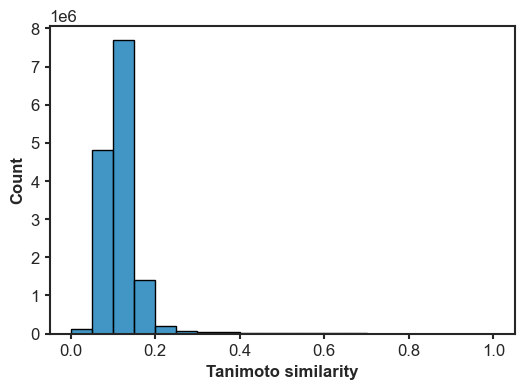

In [31]:
fig, ax = plt.subplots(figsize=(6,4))

sns.histplot(all_tanimoto_sim_1024, binwidth=0.05, edgecolor='black', ax=ax)

ax.set(xlabel='Tanimoto similarity')

plt.show()

In [32]:
log.info(f"DataFrame shape after dropping fp duplicates: {data_no_fp_dup.shape}")
log.info(f"Columns: {data_no_fp_dup.columns}")

DataFrame shape after dropping fp duplicates: (10425, 11)
Columns: Index(['SMILES', 'Source', 'Source description', 'Protein', 'Assay', 'Type',
       'Unit', 'Value', 'pK_pIC50', 'Class', 'Canon_SMILES'],
      dtype='object')


Save data with one enantiomer removed

In [33]:
data_no_fp_dup.to_csv("2023.06.13_brd_ligands_cleaned_no_fp_dups.csv")

# Looking at split between classes

Class values already included, cutoff is 5.0 for pK/pIC50 and 2.0 for Tm

Removing the problem compounds resulted in only actives (for BRD4-1 and BRD4-2) being removed

Back to being a bit imbalanced towards actives!

In [34]:
print(data_2['Class'].value_counts())

print(data_no_fp_dup['Class'].value_counts())

1    5705
0    4750
Name: Class, dtype: int64
1    5675
0    4750
Name: Class, dtype: int64


## Full dataset

Make a stacked bar chart + a standard count plot
* This still includes the duplicated fingerprints

For the stacked bar chart, need to massage the data into a particular format, so I can make one bar plot for the total counts by class and another plot for the inactives

BRPF1A is out of order, because it only has thermal shift data — use data_2_by_class["Protein"].unique() to order the bromodomains alphabetically
* It looks like the groupby also sorts the proteins alphabetically

New bromodomains are BRDT-2 and PB1-3

In [35]:
data_2_by_class = data_2.groupby(["Protein","Class"]).count().reset_index()[["Protein","Class","Canon_SMILES"]]
data_2_inactives = data_2_by_class[data_2_by_class["Class"] == 0]

data_2_protein_total = data_2["Protein"].value_counts()

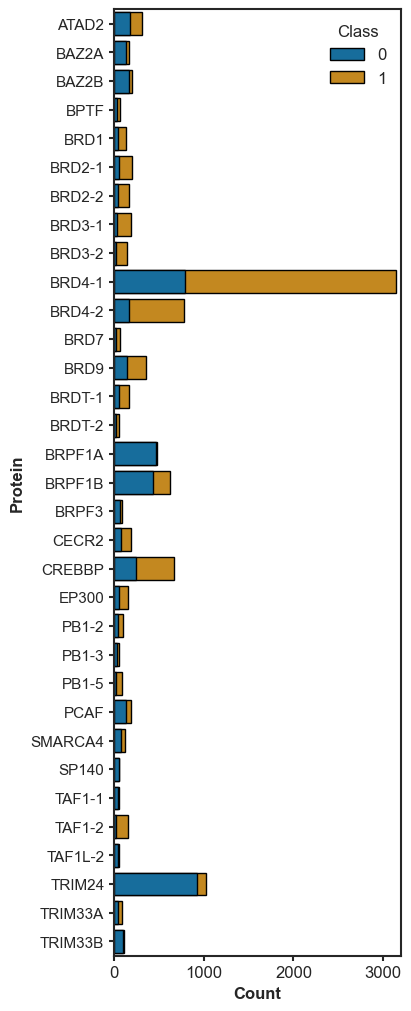

In [37]:
# with problem dups still included, this should be what I present at the get go
fig, ax = plt.subplots(figsize=(4, 10), constrained_layout=True)

# important to follow the order of the inactives dataframe
sns.barplot(
    y=data_2_protein_total.index,
    x=data_2_protein_total.values,
    color="C1",
    label="1",
    order=data_2_by_class["Protein"].unique(),
    ax=ax,
    edgecolor="black",
)
sns.barplot(
    data=data_2_inactives,
    y="Protein",
    x="Canon_SMILES",
    order=data_2_by_class["Protein"].unique(),
    color="C0",
    label="0",
    ax=ax,
    edgecolor="black",
)

ax.set(xlabel="Count", xlim=(0,3200))
ax.tick_params(axis="y", which="both", labelsize=11, rotation=0)

# reverse to get regular color ordering
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), frameon=False, title='Class', loc="upper right")

fig.savefig("2023.06.13_dataset_full_stacked.png",dpi=600)

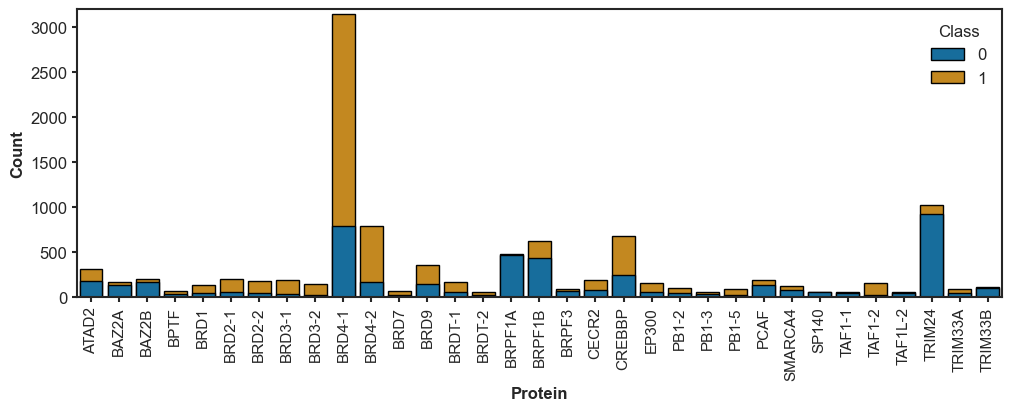

In [38]:
# with problem dups still included, this should be what I present at the get go
# protein on the x axis for ppt slides
fig, ax = plt.subplots(figsize=(10, 4), constrained_layout=True)

# important to follow the order of the inactives dataframe
sns.barplot(
    x=data_2_protein_total.index,
    y=data_2_protein_total.values,
    color="C1",
    label="1",
    order=data_2_by_class["Protein"].unique(),
    ax=ax,
    edgecolor="black",
)
sns.barplot(
    data=data_2_inactives,
    x="Protein",
    y="Canon_SMILES",
    order=data_2_by_class["Protein"].unique(),
    color="C0",
    label="0",
    ax=ax,
    edgecolor="black",
)

ax.set(ylabel="Count", ylim=(0,3200))
ax.tick_params(axis="x", which="both", labelsize=11, rotation=90)

# reverse to get regular color ordering
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), frameon=False, title='Class', loc="upper right")

fig.savefig("2023.06.13_dataset_full_stacked_protein_x.png",dpi=600)

Also make another plot without the stacked bars, where I can put the counts for each bar

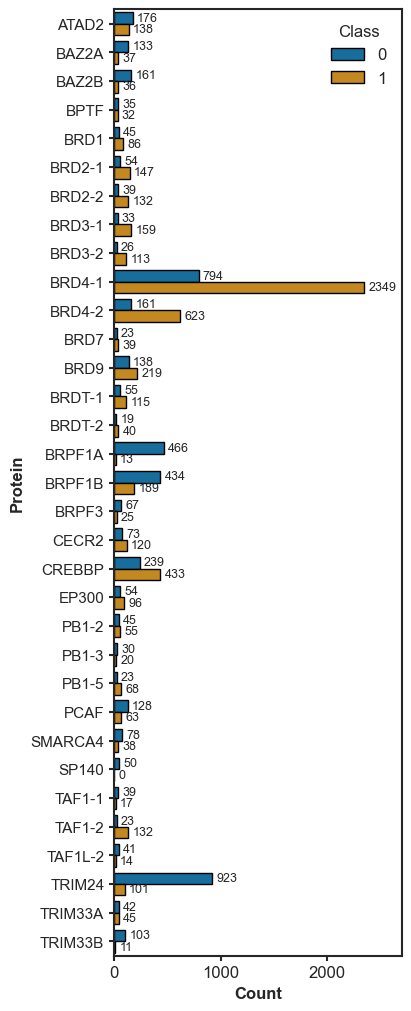

In [56]:
# with problem dups still included, this should be what I present at the get go
fig, ax = plt.subplots(figsize=(4, 10), constrained_layout=True)

sns.countplot(
    data=data_2,
    y="Protein",
    hue="Class",
    order=data_2_by_class["Protein"].unique(),
    ax=ax,
    edgecolor="Black",
)

ax.set(xlim=(0, 2700))
ax.set_xlabel("Count")
ax.tick_params(axis="y", which="both", labelsize=11, rotation=0)
for cont in ax.containers:
    ax.bar_label(cont, fontsize=9, padding=3)

ax.legend(frameon=False, title="Class", loc="upper right")

plt.show()
fig.savefig("2023.06.13_dataset_full_split.png", dpi=600)


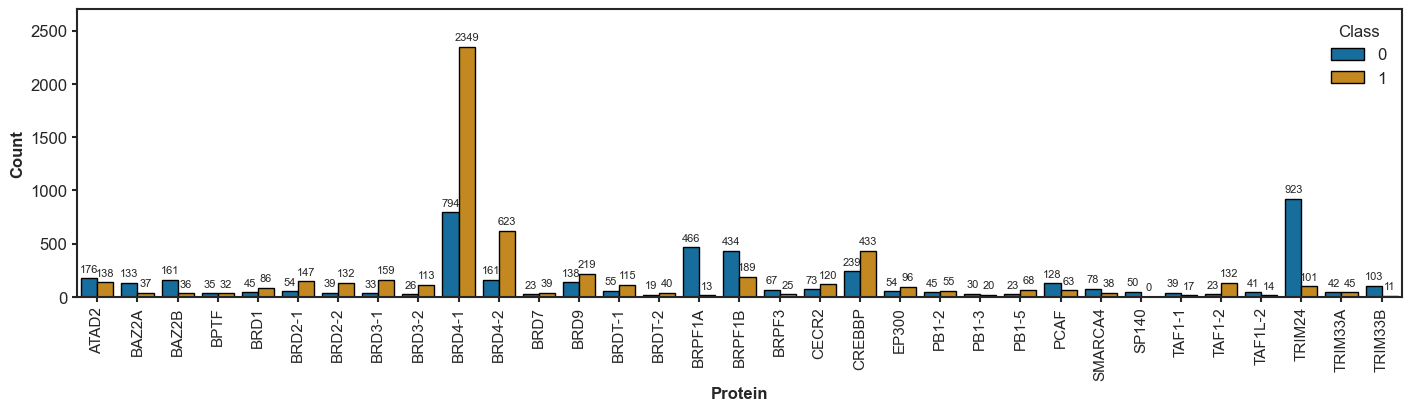

In [57]:
# with problem dups still included, this should be what I present at the get go
# protein on the x axis for ppt slides 
fig, ax = plt.subplots(figsize=(14, 4), constrained_layout=True)

sns.countplot(
    data=data_2,
    x="Protein",
    hue="Class",
    order=data_2_by_class["Protein"].unique(),
    ax=ax,
    edgecolor="Black",
)

ax.set(ylim=(0, 2700))
ax.set_ylabel("Count")
ax.tick_params(axis="x", which="both", labelsize=11, rotation=90)
for cont in ax.containers:
    ax.bar_label(cont, fontsize=8, padding=3)

ax.legend(frameon=False, title="Class", loc="upper right")

plt.show()
fig.savefig("2023.06.13_dataset_full_split_protein_x.png", dpi=600)


## Dataset with duplicated morgan fp compounds removed 

Make a stacked bar chart + a standard count plot

For the stacked bar chart, need to massage the data into a particular format, so I can make one bar plot for the total counts by class and another plot for the inactives

In [41]:
data_no_fp_dup_by_class = data_no_fp_dup.groupby(["Protein","Class"]).count().reset_index()[["Protein","Class","Canon_SMILES"]]
data_no_fp_dup_inactives = data_no_fp_dup_by_class[data_no_fp_dup_by_class["Class"] == 0]

data_no_fp_dup_protein_total = data_no_fp_dup["Protein"].value_counts()

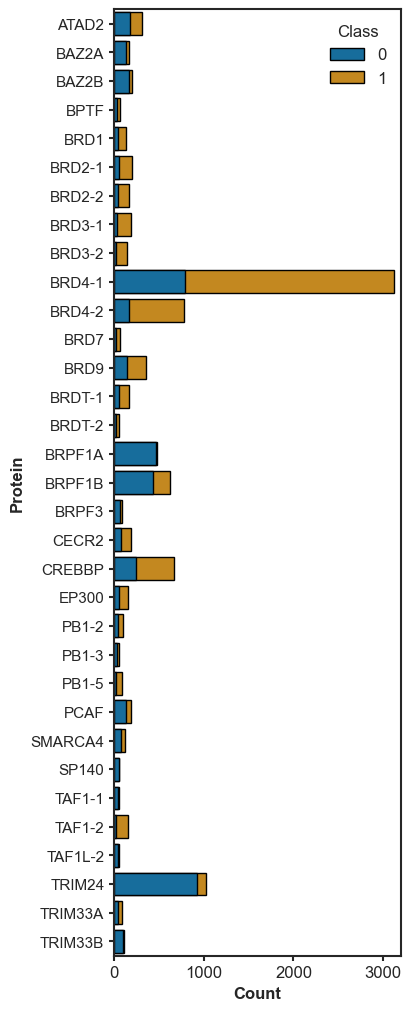

In [43]:
# with problem dups still included, this should be what I present at the get go
fig, ax = plt.subplots(figsize=(4, 10), constrained_layout=True)

# important to follow the order of the inactives dataframe
sns.barplot(
    y=data_no_fp_dup_protein_total.index,
    x=data_no_fp_dup_protein_total.values,
    color="C1",
    label="1",
    order=data_no_fp_dup_by_class["Protein"].unique(),
    ax=ax,
    edgecolor="black",
)
sns.barplot(
    data=data_no_fp_dup_inactives,
    y="Protein",
    x="Canon_SMILES",
    color="C0",
    label="0",
    order=data_no_fp_dup_by_class["Protein"].unique(),
    ax=ax,
    edgecolor="black",
)

ax.set(xlabel="Count", xlim=(0,3200))
ax.tick_params(axis="y", which="both", labelsize=11, rotation=0)

# reverse to get regular color ordering
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), frameon=False, title='Class', loc="upper right")

Also make another plot without the stacked bars, where I can put the counts for each bar

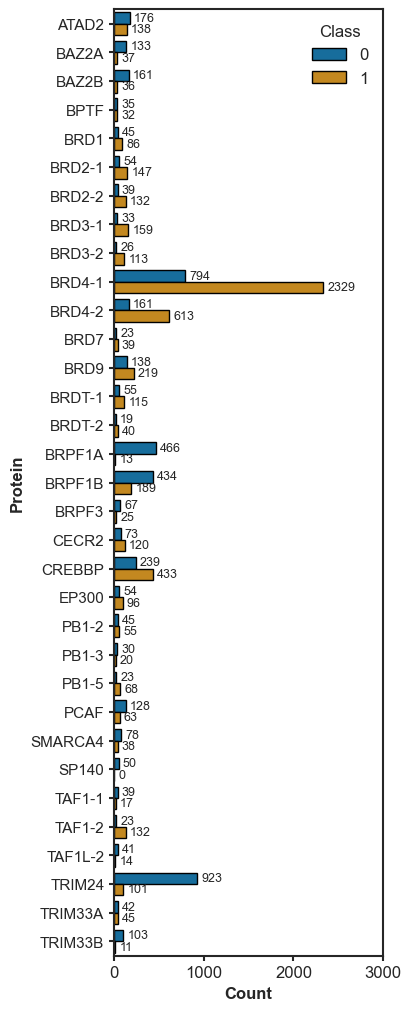

In [44]:
# with problem dups still included, this should be what I present at the get go
fig, ax = plt.subplots(figsize=(4, 10), constrained_layout=True)

sns.countplot(
    data=data_no_fp_dup,
    y="Protein",
    hue="Class",
    order=data_no_fp_dup_by_class["Protein"].unique(),
    ax=ax,
    edgecolor="Black",
)

ax.set(xlim=(0, 3000))
ax.set_xlabel("Count")
ax.tick_params(axis="y", which="both", labelsize=11, rotation=0)
for cont in ax.containers:
    ax.bar_label(cont, fontsize=9, padding=3)

ax.legend(frameon=False, title="Class", loc="upper right")

plt.show()


# Murcko Scaffolds

Do this with the full dataset first

In [45]:
PandasTools.AddMoleculeColumnToFrame(data_2, smilesCol='Canon_SMILES')
PandasTools.AddMurckoToFrame(data_2)
PandasTools.AddMoleculeColumnToFrame(data_2, smilesCol='Murcko_SMILES', molCol='Murcko_ROMol')

In [46]:
data_2["Murcko_SMILES"].describe()

count                                         10455
unique                                         2765
top       O=c1[nH]cc(-c2ccccc2Oc2ccccc2)c2cc[nH]c12
freq                                            196
Name: Murcko_SMILES, dtype: object

Display Murcko scaffolds

,SMILES,Count,Murcko_ROMol
0,O=c1[nH]cc(-c2ccccc2Oc2ccccc2)c2cc[nH]c12,196,
1,c1ccc(-c2nn3cnnc3c3ccccc23)cc1,133,
2,O=c1ccc2cc(NS(=O)(=O)c3ccccc3)ccc2[nH]1,129,
3,O=C1c2cccc3cccc(c23)C(=O)N1c1ccc2[nH]c(=O)[nH]...,99,
4,O=S(=O)(NCc1ccccc1)c1cccc(-c2nn3cnnc3c3ccccc23)c1,98,
...,...,...,...
2760,c1ccc(CCc2nc3cc(-c4cnoc4)ccc3n2C2CCOCC2)cc1,1,
2761,O=C1C[C@H](c2nc3cc(-c4cnoc4)ccc3n2C2CCCCC2)N1c...,1,
2762,O=C1C[C@@H](c2nc3cc(-c4cnoc4)ccc3n2C2CCCCC2)N1...,1,
2763,O=c1cc(Cc2nc3cc(-c4cnoc4)ccc3n2C2CCCCC2)c2cccc...,1,

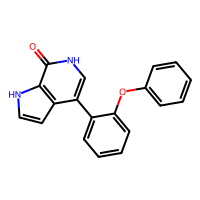
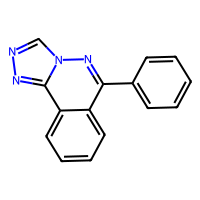
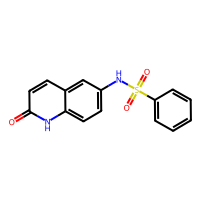
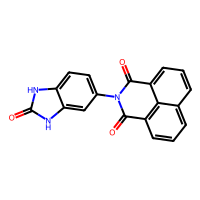
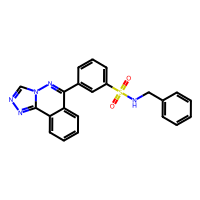
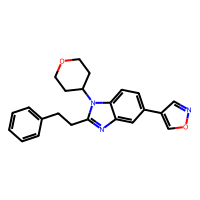
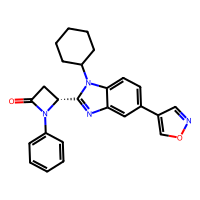
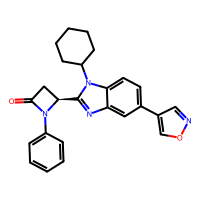
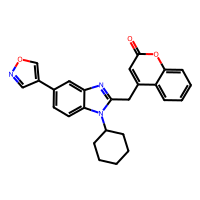
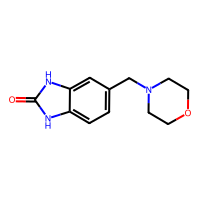

In [47]:
murcko_counts = data_2['Murcko_SMILES'].value_counts().to_frame().reset_index()
murcko_counts.columns = ["SMILES", "Count"]
PandasTools.AddMoleculeColumnToFrame(murcko_counts, smilesCol="SMILES", molCol="Murcko_ROMol")
display(murcko_counts)

Check the dataset with fp duplicates removed
* Some unique scaffolds are gone, but those seem to be low frequency

In [48]:
PandasTools.AddMoleculeColumnToFrame(data_no_fp_dup, smilesCol='Canon_SMILES')
PandasTools.AddMurckoToFrame(data_no_fp_dup)
PandasTools.AddMoleculeColumnToFrame(data_no_fp_dup, smilesCol='Murcko_SMILES', molCol='Murcko_ROMol')

In [49]:
data_no_fp_dup["Murcko_SMILES"].describe()

count                                         10425
unique                                         2746
top       O=c1[nH]cc(-c2ccccc2Oc2ccccc2)c2cc[nH]c12
freq                                            196
Name: Murcko_SMILES, dtype: object

# Checking for bit clashes

Since I've decided to try Morgan fingerprints with radius 3 below, want to see whether it results in more bit collisions.

tl;dr not that much more than using a radius of 2.

In [50]:
def get_bit_clashes(mol, radius=2, bits=1024):
    hashed_fp = rdMolDescriptors.GetHashedMorganFingerprint(mol, radius, bits, useChirality=1)
    clashes = 0
    for k, v in hashed_fp.GetNonzeroElements().items():
        if v > 1:
            clashes += 1
    
    return clashes

In [51]:
fp_lengths = [256, 512, 1024, 2048, 4096]

for bits in fp_lengths:
    clashes = np.zeros(len(ligand_mols))
    for i, mol in enumerate(ligand_mols):
        clashes[i] = get_bit_clashes(mol, radius=2, bits=bits)
        
    print(np.mean(clashes))

14.650297619047619
13.30952380952381
12.653831845238095
12.366815476190476
12.172061011904763


Going up to radius 3, at 1024 bits, get 1 additional bit clash on average, so not too bad...

In [52]:
fp_lengths = [256, 512, 1024, 2048, 4096]

for bits in fp_lengths:
    clashes = np.zeros(len(ligand_mols))
    for i, mol in enumerate(ligand_mols):
        clashes[i] = get_bit_clashes(mol, radius=3, bits=bits)
        
    print(np.mean(clashes))

18.15141369047619
15.441592261904763
13.945684523809524
13.165178571428571
12.749441964285714
